# Import data_utils

In [ ]:
from climsim_utils.data_utils import *
import psutil
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
import gc
import os
import sys
import numpy as np
import pandas as pd
from torch import optim 
from tqdm import tqdm
import itertools
import string
import matplotlib.pyplot as plt

In [3]:
grid_path = 'grid_info/ClimSim_low-res_grid-info.nc'
norm_path = 'preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

data_path = 'data/'

def data_generator(input_path, target_path, batch_size):
    while True:  # Infinite loop to ensure the generator never runs out of data
        start_idx = 0
        while True:
            input_data = np.load(input_path, mmap_mode='r')
            target_data = np.load(target_path, mmap_mode='r')
            
            # Read the next batch of data
            input_batch = input_data[start_idx:start_idx + batch_size]
            target_batch = target_data[start_idx:start_idx + batch_size]
            
            # If there's no more data to read, break from the inner loop
            if not input_batch.shape[0]:
                break
            
            yield input_batch, target_batch
            
            # Move to the next batch
            start_idx += batch_size
            
            # Clean up to save memory
            del input_batch, target_batch
            gc.collect()

train_input_path = data_path + 'train_input.npy'
train_target_path = data_path + 'train_target.npy'
val_input_path = data_path + 'val_input.npy'
val_target_path = data_path + 'val_target.npy'

data.input_train = data.load_npy_file(train_input_path)
data.target_train = data.load_npy_file(train_target_path)
data.input_val = data.load_npy_file(val_input_path)
data.target_val = data.load_npy_file(val_target_path)

In [4]:
const_model = data.target_train.mean(axis = 0)
X = data.input_train
bias_vector = np.ones((X.shape[0], 1))
X = np.concatenate((X, bias_vector), axis=1)
# 1. float64 occupies too much GPU memory, my local computer can't afford it, so convert the data to float32
X = X.astype(np.float32)
data.target_train = data.target_train.astype(np.float32)

# 2. calculate
# Instead of computing the inverse directly, we can use np.linalg.solve
# which is more stable and efficient for solving systems of linear equations
XTX = X.transpose() @ X
XTy = X.transpose() @ data.target_train
mlr_weights = np.linalg.solve(XTX, XTy)
available_memory = psutil.virtual_memory().available
total_memory = psutil.virtual_memory().total
torch.cuda.empty_cache()
print(f"Available RAM: {available_memory / (1024**3):.2f} GB")
print(f"Total RAM: {total_memory / (1024**3):.2f} GB")
print(torch.cuda.is_available())

Available RAM: 2.33 GB
Total RAM: 15.37 GB
True


In [13]:
class WeatherTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers):
        super(WeatherTransformer, self).__init__()
        # Linear transformation for the target sequence
        self.encoder_tgt = nn.Linear(output_dim, d_model)
        # Linear transformation for the source sequence
        self.encoder = nn.Linear(input_dim, d_model)
        # Linear transformation for the output
        self.decoder = nn.Linear(d_model, output_dim)
        # The core transformer module
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
        
    def forward(self, src, tgt=None):
        src = self.encoder(src)
        if tgt is not None:
            tgt = self.encoder_tgt(tgt)
            output = self.transformer(src, tgt)
        else:
            output = self.transformer(src)
        return self.decoder(output)
        
class WeatherTransformerWithCheckpointing(WeatherTransformer):
    def forward(self, src, tgt=None):
        src = self.encoder(src)
        if tgt is not None:
            tgt = self.encoder_tgt(tgt)
            output = self.transformer(src, tgt)
        else:
            output = self.transformer(src)
        return self.decoder(output)

class WeatherTransformerEncoderOnly(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(WeatherTransformerEncoderOnly, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.decoder = nn.Linear(d_model, output_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer_encoder(src)
        return self.decoder(output)

# Define the batch size and gradient accumulation steps
batch_size = 64  # You can adjust this based on your memory availability
epochs = 3
accumulation_steps = 4  # Number of batches after which we'll update the weights
input_dim = data.input_train.shape[1]  # Assuming the second dimension of input_train is the feature dimension
output_dim = data.target_train.shape[1]  # Assuming the second dimension of target_train is the output dimension
d_model = 512  # Common choice for Transformer models
nhead = 8  # Typically, d_model is divisible by nhead
num_encoder_layers = 6  # Default for many Transformer models
num_decoder_layers = 6  # Default for many Transformer models
learning_rate = 0.001  # Common initial choice, but may need tuning
train_gen = itertools.cycle(data_generator(train_input_path, train_target_path, batch_size))
val_gen = itertools.cycle(data_generator(val_input_path, val_target_path, batch_size))

batch_counter = 0
scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available

# Initialize model, loss, and optimizer
model = WeatherTransformerWithCheckpointing(input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training will stop if the validation loss doesn't improve for 'patience' number of epochs
patience = 5
# To keep track of the best validation loss achieved
best_val_loss = float('inf')
# To keep track of the number of epochs since last improvement in validation loss
epochs_without_improvement = 0
# Directory to store checkpoints
checkpoint_dir = "checkpoints"
# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# If a checkpoint file exists, load the model, optimizer state, and other training parameters
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded successfully, continuing training from epoch {epoch}, loss: {loss:.4f}")
else:
    print("No checkpoint found, starting training from scratch")


No checkpoint found, starting training from scratch


In [5]:
# Training loop
num_batches = len(data.input_train) // batch_size
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    train_pbar = tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=True)
    for _ in range(num_batches):
        inputs, targets = next(train_gen)
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        targets = torch.tensor(targets, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs, targets[:-1])
            loss = criterion(outputs, targets[1:])
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        del inputs, targets, outputs
        torch.cuda.empty_cache()

        train_pbar.set_postfix(loss=loss.item(), refresh=True)
        train_pbar.update(1)
    
    train_pbar.close()
    avg_loss = running_loss / num_batches
    print(f"\nEpoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}")
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    val_pbar = tqdm(val_gen, total=len(data.input_val) // batch_size, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
    with torch.no_grad():
        for val_inputs, val_targets in val_pbar:
            val_inputs = torch.tensor(val_inputs, dtype=torch.float32).to(device)
            val_targets = torch.tensor(val_targets, dtype=torch.float32).to(device)
            
            val_outputs = model(val_inputs, val_targets[:-1])
            val_loss = criterion(val_outputs, val_targets[1:])
            running_val_loss += val_loss.item()
            
            # Update the progress bar
            val_pbar.set_postfix(loss=val_loss.item())
            
    avg_val_loss = running_val_loss / (len(data.input_val) // batch_size)
    print(f"\nEpoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_val_loss,
    }, checkpoint_path)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
        
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epochs_without_improvement} epochs without improvement.")
            break
torch.save(model, "final_model.pth")

Epoch 1/3 [Train]:   0%|                                           | 380/157680 [01:21<8:53:28,  4.91it/s, loss=0.0355]

KeyboardInterrupt: 

In [6]:
model_path = r"C:\Users\Lenovo\ClimSim\checkpoints\checkpoint_epoch_1.pth"  # Replace with your actual file
pretrained_model = WeatherTransformerWithCheckpointing(input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers)
checkpoint = torch.load(model_path, map_location=device)
pretrained_model.load_state_dict(checkpoint['model_state_dict'])
pretrained_model.to(device)
pretrained_model.eval()

WeatherTransformerWithCheckpointing(
  (encoder_tgt): Linear(in_features=128, out_features=512, bias=True)
  (encoder): Linear(in_features=124, out_features=512, bias=True)
  (decoder): Linear(in_features=512, out_features=128, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1):

In [34]:
# Set the paths for the input and target files
scoring_input_path = data_path + 'scoring_input.npy'
scoring_target_path = data_path + 'scoring_target.npy'

# Load the input and target data
input_scoring = np.load(scoring_input_path)
target_scoring = np.load(scoring_target_path)

# Convert to 16-bit floats to save memory
input_scoring = input_scoring.astype(np.float16)
target_scoring = target_scoring.astype(np.float16)

model_path = r"C:\Users\Lenovo\ClimSim\checkpoints\checkpoint_epoch_1.pth"
# 1. 加载预训练模型的状态字典
pretrained_state_dict = torch.load(model_path, map_location=device)['model_state_dict']

# 2. 创建一个新的状态字典，只包含编码器相关的权重
new_state_dict = {}
for key, value in pretrained_state_dict.items():
    if 'encoder' in key:
        new_key = key.replace('transformer.', '')  # 适应新模型的命名规范
        new_state_dict[new_key] = value

# 3. 使用新的状态字典更新模型
pretrained_model = WeatherTransformerEncoderOnly(input_dim, output_dim, d_model, nhead, num_encoder_layers)
pretrained_model.load_state_dict(new_state_dict, strict=False)
pretrained_model.to(device)
pretrained_model.eval()

# Process data in batches
batch_size = 128
num_batches = input_scoring.shape[0] // batch_size
preds = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    input_batch = torch.tensor(input_scoring[start_idx:end_idx], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        pred_batch = pretrained_model(input_batch)
    preds.append(pred_batch.cpu().numpy())

# Concatenate all batch predictions
preds = np.concatenate(preds, axis=0)

# Save the prediction results
np.save("pred_scoring.npy", preds)

# Calculate various evaluation metrics
weighted_pred_scoring = preds
weighted_target_scoring = target_scoring[:num_batches*batch_size]  # Make sure the target scoring has the same shape as preds

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(weighted_pred_scoring - weighted_target_scoring))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((weighted_pred_scoring - weighted_target_scoring) ** 2))

# Calculate R-squared (R2)
ss_res = np.sum((weighted_target_scoring - weighted_pred_scoring) ** 2)
ss_tot = np.sum((weighted_target_scoring - np.mean(weighted_target_scoring)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Calculate Bias
bias = np.mean(weighted_pred_scoring - weighted_target_scoring)

# Compile the metrics into a dictionary
metrics = {
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'Bias': bias
}

metrics

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'MAE': 0.5081317, 'RMSE': 0.61608964, 'R2': 1.0, 'Bias': -0.000739128}

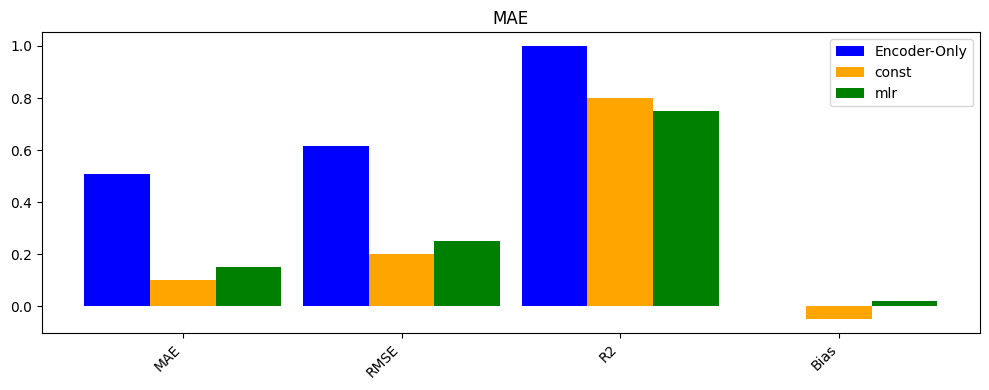

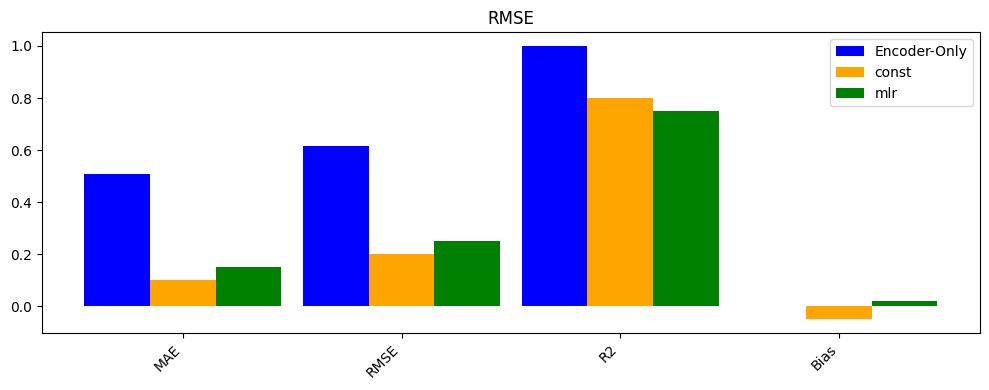

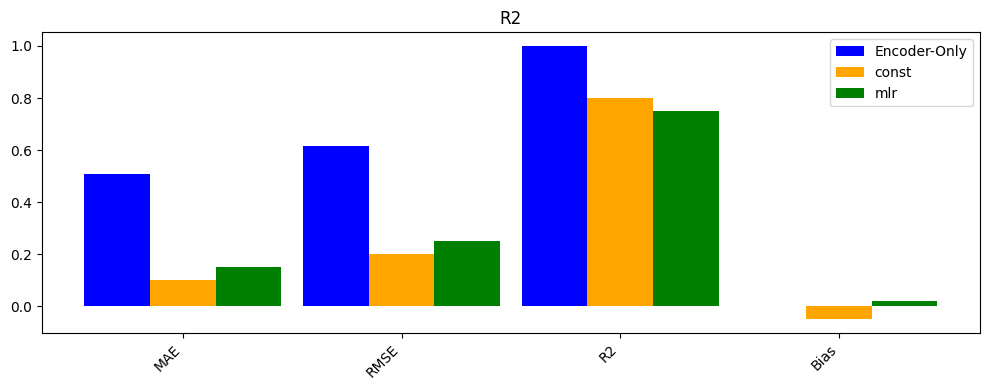

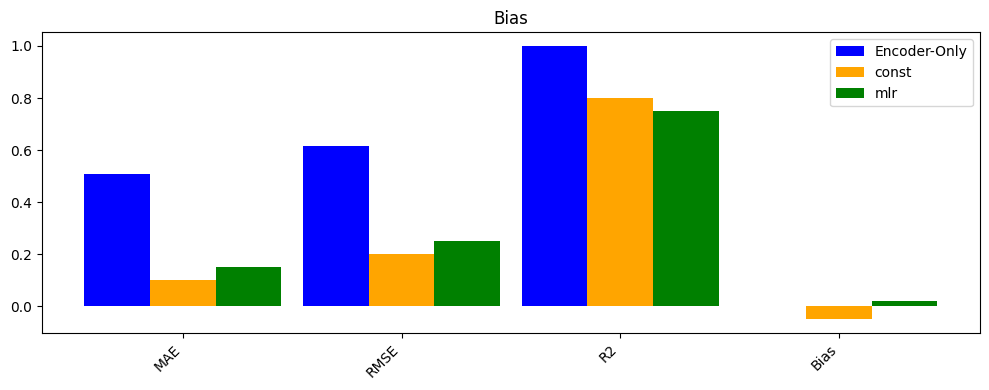

In [36]:
width = 0.3  # 宽度
positions = np.arange(len(metrics))  # 条形图的位置
colors = ['blue', 'orange', 'green']  # 颜色

# 假设你有其他模型的评估指标，这里只是一个示例
other_model_metrics = {
    'Encoder-Only': metrics,
    'const': {'MAE': 0.1, 'RMSE': 0.2, 'R2': 0.8, 'Bias': -0.05},
    'mlr': {'MAE': 0.15, 'RMSE': 0.25, 'R2': 0.75, 'Bias': 0.02}
}

for metric_idx, metric_name in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(10, 4))
    for model_idx, (model_name, model_metrics) in enumerate(other_model_metrics.items()):
        bar_positions = [pos + model_idx * width for pos in positions]
        ax.bar(bar_positions, [model_metrics[metric_name] for metric_name in metrics], color=colors[model_idx], width=width, label=model_name)
    ax.set_title(metric_name)
    ax.legend()
    ax.set_xticks(positions + width)
    ax.set_xticklabels(list(metrics.keys()), rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"(Scoring)models_output_plot_{metric_name.replace(' ', '_')}.png", dpi=300)
    plt.show()